<a href="https://colab.research.google.com/github/KassenBoyaubay/MPA-MLF-Exercises/blob/main/Finalproject/Finalproject_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MPA-MLF, Finalproject
### *Kassen Boyaubay*

## 0. Import libraries

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from keras.utils import to_categorical
from keras import layers, Model, Sequential, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# from sklearn import decomposition
# from keras import regularizers
# from sklearn import preprocessing
# from sklearn import decomposition
# from sklearn.svm import LinearSVC
# from numpy import argmax

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## 1. Mount Files

In [2]:
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Dataset/'
x_train_dir = os.path.join(base_dir, 'Train/Color/')
x_test_dir = os.path.join(base_dir, 'Test/Color/')
y_train_dir = os.path.join(base_dir, 'y_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data examination

### 2.1 Size of the dataset

In [3]:
print('total training images:', len(os.listdir(x_train_dir)))
print('total test images:', len(os.listdir(x_test_dir)))

total training images: 8279
total test images: 3562


### 2.2 Explore the image

Image shape:  (539, 682, 3)


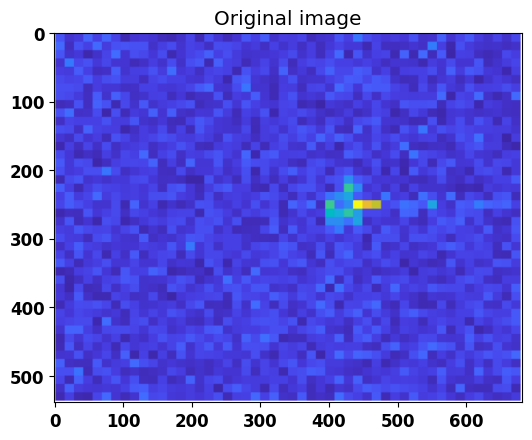

In [4]:
img = np.asarray(Image.open(x_train_dir + 'img_0.png'))

plt.imshow(img)
plt.title('Original image')

print('Image shape: ', img.shape)

### 2.3 Explore the labels

In [5]:
y_train = pd.read_csv(y_train_dir)
print(y_train.iloc[0:4])
print('y_train shape:', y_train.shape)
print('\ny_train unique values:', y_train['target'].unique())
print('labels:', len(y_train['target'].unique()))

   id  target
0   0       1
1   1       3
2   2       1
3   3       1
y_train shape: (8279, 2)

y_train unique values: [1 3 2]
labels: 3


## 3. Data preprocessing

### Compression

In [6]:
resize = (160, 160)

In [7]:
zoom = 0.2

In [8]:
(img_height, img_width, _) = img.shape
top = round(zoom*img_height/2)
left = round(zoom*img_width/2)
bottom = img_height - top
right = img_width - left

In [9]:
crop_sizes = (left, top, right, bottom)

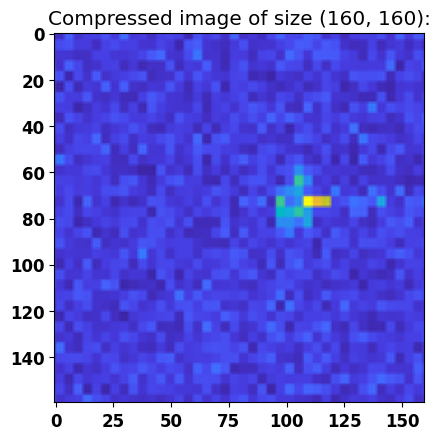

In [10]:
plt.imshow(np.asarray(Image.open(x_train_dir + 'img_0.png').crop(crop_sizes).resize(resize, Image.ANTIALIAS)))
plt.title('Compressed image of size ' + str(resize) + ':')
print()

### 3.1 geting all sorted filenames

In [11]:
def sorting_files(st): 
    nr_part = st.split("_")[1]  # returns "number.png"
    int_part = nr_part.split(".")[0] # returns "number"
    int_part = int_part.split('(1)')[0]
    return int(int_part)
ccc = os.listdir(x_train_dir)
print(sorted(ccc, key=sorting_files))

['img_0.png', 'img_1.png', 'img_2.png', 'img_3.png', 'img_4.png', 'img_5.png', 'img_6.png', 'img_7.png', 'img_8.png', 'img_9.png', 'img_10.png', 'img_11.png', 'img_12.png', 'img_13.png', 'img_14.png', 'img_15.png', 'img_16.png', 'img_17.png', 'img_18.png', 'img_19.png', 'img_20.png', 'img_21.png', 'img_22.png', 'img_23.png', 'img_24.png', 'img_25.png', 'img_26.png', 'img_27.png', 'img_28.png', 'img_29.png', 'img_30.png', 'img_31.png', 'img_32.png', 'img_33.png', 'img_34.png', 'img_35.png', 'img_36.png', 'img_37.png', 'img_38.png', 'img_39.png', 'img_40.png', 'img_41.png', 'img_42.png', 'img_43.png', 'img_44.png', 'img_45.png', 'img_46.png', 'img_47.png', 'img_48.png', 'img_49.png', 'img_50.png', 'img_51.png', 'img_52.png', 'img_53.png', 'img_54.png', 'img_55.png', 'img_56.png', 'img_57.png', 'img_58.png', 'img_59.png', 'img_60.png', 'img_61.png', 'img_62.png', 'img_63.png', 'img_64.png', 'img_65.png', 'img_66.png', 'img_67.png', 'img_68.png', 'img_69.png', 'img_70.png', 'img_71.png', '

### 3.2 x_train preprocessing

In [16]:
x_train_dir_filenames = sorted(os.listdir(x_train_dir), key=sorting_files)
x_train = []
for filename in x_train_dir_filenames:
  x_train.append(np.asarray(Image.open(x_train_dir + filename).crop(crop_sizes).resize(resize, Image.ANTIALIAS)))
x_train = np.array(x_train)
print(x_train.shape)

(8279, 160, 160, 3)


#### Normalize x_train

In [17]:
x_train = x_train.astype('float32')
x_train /= 255

#### Save x_train

In [18]:
# save numpy array as npz file
from numpy import savez_compressed
# save to npy file
savez_compressed('/content/drive/MyDrive/x_train_160.npz', x_train)

#### Load x_train

In [11]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('/content/drive/MyDrive/x_train_160.npz')
# extract the first array
x_train = dict_data['arr_0']

### 3.3 x_test preprocessing

In [53]:
x_test_dir_filenames = sorted(os.listdir(x_test_dir), key=sorting_files)
for s in x_test_dir_filenames:
  if '(1)' in s:
    x_test_dir_filenames.remove(s)
x_test = []
for filename in x_test_dir_filenames:
  x_test.append(np.asarray(Image.open(x_test_dir + filename).crop(crop_sizes).resize(resize, Image.ANTIALIAS)))
x_test = np.array(x_test)
print(x_test.shape)

(3549, 160, 160, 3)


In [57]:
print('number of test data samples: ', len(x_test_dir_filenames))
print('first item:', x_test_dir_filenames[0])
print('last item:', x_test_dir_filenames[-1])

number of test data samples:  3549
first item: img_0.png
last item: img_3548.png


#### Normalize x_test

In [54]:
x_test = x_test.astype('float32')
x_test /= 255

#### Save x_test

In [55]:
# save numpy array as npz file
from numpy import savez_compressed
# save to npy file
savez_compressed('/content/drive/MyDrive/x_test_160.npz', x_test)

#### Load x_test

In [12]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('/content/drive/MyDrive/x_test_160.npz')
# extract the first array
x_test = dict_data['arr_0']

### 3.4 y_train preprocessing

In [13]:
num_classes = len(y_train['target'].unique())
y_train_encoded = to_categorical(y_train['target'].values-1, num_classes).astype('int32')
print('"target" values as array: ', y_train['target'].values)
print('one-hot encoded: \n', y_train_encoded)

"target" values as array:  [1 3 1 ... 2 1 2]
one-hot encoded: 
 [[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 1 0]]


### 3.5 train test split

In [14]:
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train_encoded, test_size=0.2)

## 4. CNN model

### 4.1 Build CNN model

In [15]:
input_shape = resize + (3, )

model = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),    
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
     
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),                                      
        layers.Dropout(0.2),
     
        layers.Flatten(),
     
        layers.Dense(256, activation="relu"),
        # layers.BatchNormalization(),
        layers.Dropout(0.2),
     
        layers.Dense(128, activation="relu"),
        # layers.BatchNormalization(),
        # layers.Dropout(0.2),
     
        # layers.Dense(128, activation="gelu"),
        # layers.BatchNormalization(),
        # layers.Dropout(0.2),
     
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 158, 158, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 79, 79, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 77, 77, 64)       2

### 4.2 Train CNN model

In [16]:
callback = EarlyStopping(
          # Stop training when `val_loss` is no longer improving
          monitor='val_loss',
          # "no longer improving" being defined as "no better than 1e-2 less"
          min_delta=1e-3,
          # "no longer improving" being further defined as "for at least 2 epochs"
          patience=25,
          verbose=1)

class weights

In [18]:
y_integers = np.argmax(y_train_split, axis=1)
class_weights = class_weight.compute_class_weight(
                                                    class_weight = "balanced",
                                                    classes=np.unique(y_integers),
                                                    y = y_integers
                                                  )
d_class_weights = dict(enumerate(class_weights))

In [ ]:
batch_size = 64
epochs = 100

optimizer = Adam(
    learning_rate=0.01,
)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(x_train_split, y_train_split, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=2, callbacks=[callback])

Epoch 1/100
83/83 - 26s - loss: 11.9180 - accuracy: 0.5213 - val_loss: 2.6465 - val_accuracy: 0.4370 - 26s/epoch - 313ms/step
Epoch 2/100


### 4.3 Evaluate trained CNN model

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('n epochs')
plt.ylabel('loss')

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('n epochs')
plt.ylabel('loss')

## 5. Model prediction

In [ ]:
y_pred_enc = model.predict(x_test)

ValueError: in user code:

    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 128, 128, 3)


## 6. Export to CSV

In [ ]:
indexes = argmax(y_pred_enc, axis=1)
y_pred = indexes + 1

In [ ]:
y_pred_postpr = pd.DataFrame({'id': np.arange(0, len(y_pred)), 'target': y_pred})

In [ ]:
y_pred_postpr.to_csv('y_pred_mlp.csv', index=False)